## MSCRED (Multi Scale Convolutional Recurrent Encoder Decoder)

Ce script vise  a tester toutes les briques qui compose le pipeline MSCRED sur des données fictives pour ensuite créer le module qui sera utile dans notre projet de détection d'anomalie dans les flux de diagnostiques magnétique de tokamak !

### 1. Création des jeux de données et visualisation

1. Créer des signaux multivariés aléatoires et les visualiser. (ils constitueront le jeu d'entrainement)
2. Reprendre ce jeu synthétique et pour un sous-groupe, y ajouter des valeurs abérantes pour qu'ils soient les anomalies à détecter. Labeliser le tout (constituera le jeu de test).

In [19]:
import numpy as np
import matplotlib.pyplot as plt

In [91]:
def generate_multivariate_ts(n_variables, n_timesteps, noise_level=0.1, seed=None):
    """
    Generates realistic multivariate time series with temporal continuity and noise.
    
    Args:
        n_variables (int): Number of time series (variables)
        n_timesteps (int): Length of time series
        noise_level (float): Gaussian noise level (standard deviation)
        seed (int): Seed for reproducibility
        
    Returns:
        np.array: Matrix of time series of shape (n_variables, n_timesteps)
    """

    if seed is not None:
        np.random.seed(seed)
    
    # Matrice initialization
    data = np.zeros((n_variables, n_timesteps))
    
    # Unique parameters for each variable
    means = np.random.uniform(-10, 10, n_variables)             # Means
    volatilities = np.random.uniform(0.1, 1.0, n_variables)     # Volatilities
    trends = np.random.uniform(-0.05, 0.05, n_variables)        # Trends
    frequencies = np.random.uniform(0.01, 0.2, n_variables)     # frequencies
    
    for i in range(n_variables):
        # Random generation of the base time series (AR(1) process)
        base = np.zeros(n_timesteps)
        base[0] = np.random.normal(means[i], volatilities[i])
        
        # Adding temporal continuity
        for t in range(1, n_timesteps):
            # Autoregressive component with trend and seasonality
            drift = trends[i] * t
            season = 0.5 * np.sin(2 * np.pi * frequencies[i] * t)
            innovation = np.random.normal(0, volatilities[i])
            
            base[t] = (0.8 * base[t-1] + 0.2 * base[0] + 
                       drift + season + innovation)
        
        data[i] = base
    
    # Adding Gaussian noise
    noise = np.random.normal(0, noise_level, (n_variables, n_timesteps))
    return data + noise

In [92]:
def generate_multivariate_ts(n_variables: int, n_timesteps: int, noise_level: float = 0.1, seed:bool = None) -> np.ndarray:
    """
    Version améliorée avec contrôle des amplitudes et sinus à grande échelle.
    
    Args:
        n_variables (int): Nombre de séries temporelles
        n_timesteps (int): Longueur des séries
        noise_level (float): Niveau de bruit (écart-type)
        seed (int): Seed pour reproductibilité
        
    Returns:
        np.array: Matrice de forme (n_variables, n_timesteps)
    """
    if seed is not None:
        np.random.seed(seed)
    
    data = np.zeros((n_variables, n_timesteps))
    time = np.arange(n_timesteps)
    
    # Paramètres uniques pour chaque série
    base_amps = np.random.uniform(5, 20, n_variables)  # Amplitude de base
    slow_freqs = np.random.uniform(0.001, 0.01, n_variables)  # Fréquences lentes
    fast_freqs = np.random.uniform(0.05, 0.2, n_variables)  # Fréquences rapides
    phases = np.random.uniform(0, 2*np.pi, n_variables)  # Déphasages
    
    for i in range(n_variables):
        # Composante principale (sinus lente)
        slow_wave = base_amps[i] * np.sin(2 * np.pi * slow_freqs[i] * time + phases[i])
        
        # Composante secondaire (sinus rapide)
        fast_wave = 0.5 * base_amps[i] * np.sin(2 * np.pi * fast_freqs[i] * time)
        
        # Bruit auto-corrélé (processus AR)
        ar_noise = np.zeros(n_timesteps)
        ar_noise[0] = np.random.normal(0, 1)
        for t in range(1, n_timesteps):
            ar_noise[t] = 0.7 * ar_noise[t-1] + np.random.normal(0, 0.5)
        
        # Combinaison
        data[i] = slow_wave + fast_wave + ar_noise
    
    # Bruit de mesure et normalisation finale
    noise = np.random.normal(0, noise_level, (n_variables, n_timesteps))
    data = data + noise
    return (data - np.mean(data, axis=1, keepdims=True)) / np.std(data, axis=1, keepdims=True)

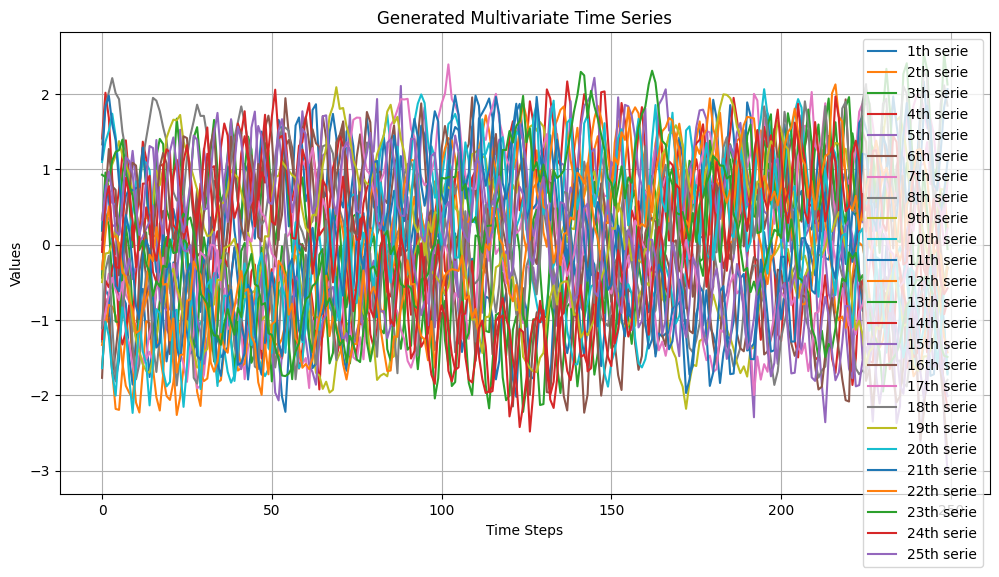

In [93]:
data_train = generate_multivariate_ts(
    n_variables=25,
    n_timesteps=250,
    noise_level=1.0,
    seed=42
)

plt.figure(figsize=(12, 6))
for i in range(data_train.shape[0]):
    plt.plot(data_train[i], label=f'{i+1}th serie')
plt.title('Generated Multivariate Time Series')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

### 2. Generate "correlation" matrixes from thosee times series.

In [94]:
def generate_signature_matrix(
    data: np.ndarray,
    win_size: list[int] = [10, 30, 60],
    min_time: int = 0,
    max_time: int = None,
    gap_time: int = 10,
    normalize: bool = True,
    save_path: str = None
) -> list[np.ndarray]:
    """
    Generates multi-scale signature matrices from multivariate time series.
    
    Args:
        data: Input data in the form (n_sensors, n_timesteps)
        win_size: List of window sizes
        min_time: Starting time point
        max_time: Ending time point (if None, uses total length)
        gap_time: Interval between segments
        normalize: If True, applies min-max normalization
        save_path: Path to save matrices (if None, no save)
    
    Returns:
        List of signature matrices for each window [win1, win2, ...]
        Each element i is an array of shape (win_i, n_sensors, n_sensors)
    """
    if max_time is None:
        max_time = data.shape[1]
    
    sensor_n = data.shape[0]
    
    # Min-Max normalization
    if normalize:
        min_val = np.min(data, axis=1, keepdims=True)
        max_val = np.max(data, axis=1, keepdims=True)
        data = (data - min_val) / (max_val - min_val + 1e-6)
    
    results = []
    
    for win in win_size:
        print(f"Generating signature matrices with window {win}...")
        matrices = []
        
        for t in range(min_time, max_time, gap_time):
            if t < win:  # Not enough data for the window
                mat = np.zeros((sensor_n, sensor_n))
            else:
                segment = data[:, t-win:t]
                mat = np.zeros((sensor_n, sensor_n))
                
                for i in range(sensor_n):
                    for j in range(i, sensor_n):
                        mat[i,j] = np.inner(segment[i], segment[j]) / win
                        mat[j,i] = mat[i,j]  # Symetry
                        
            matrices.append(mat)
        
        matrices_array = np.array(matrices)
        results.append(matrices_array)
        
        if save_path:
            np.save(f"{save_path}/matrix_win_{win}.npy", matrices_array)
    
    print("Signature matrix generation completed!")
    return results

In [95]:
win_size = [5, 10, 20]
min_time = 0
max_time = None
gap_time = 10
normalize = True

signature_matrices = generate_signature_matrix(
        data=data_train,
        win_size=win_size,
        min_time=min_time,
        max_time=max_time,
        gap_time=gap_time,
        normalize=normalize,
        save_path=None
    )

Generating signature matrices with window 5...
Generating signature matrices with window 10...
Generating signature matrices with window 20...
Signature matrix generation completed!


In [96]:
from matplotlib.gridspec import GridSpec

def plot_signature_matrices(data: np.ndarray, matrices: list[np.ndarray], win_sizes: list[int] = [10, 30, 60], gap_time: int = 10, sample_times: list[int] = [0, 100, 200]) -> None:
    """
    Visualizes signature matrices with their source time series.
    
    Args:
        data (np.ndarray): Input data in the form (n_sensors, n_timesteps)
        matrices (list[np.array]): Multivariate data (n_sensors, n_timesteps)
        win_sizes (list): Analyzed window sizes
        gap_time (int): Time step between segments
        sample_times (list): Times to visualize (e.g., [start, middle, end])

    Returns:
        None: Displays the matrices and time series
    """
    # Figure setup
    plt.figure(figsize=(18, 12))
    gs = GridSpec(3, 4, width_ratios=[1, 1, 1, 0.05])
    
    # Source time series
    ax_ts = plt.subplot(gs[:, 0])
    for i in range(min(5, data.shape[0])):  # max 5 series
        ax_ts.plot(data[i], alpha=0.7, label=f'{i+1}th sensor')
    ax_ts.set_title("Original Time Series")
    ax_ts.set_xlabel("Time")
    ax_ts.set_ylabel("Normalized Value")
    ax_ts.legend()
    
    # Matrixes visualization
    vmin = min(np.min(mat) for mat in matrices)
    vmax = max(np.max(mat) for mat in matrices)
    for i, win in enumerate(win_sizes):
        for j, t in enumerate(sample_times):
            ax = plt.subplot(gs[i, j+1])
            matrix_idx = t // gap_time
            mat = matrices[i][matrix_idx]
            
            # Divergent colormap (to see negative/positive correlations)
            im = ax.imshow(mat, cmap='RdYlBu_r', vmin=vmin, vmax=vmax)
            ax.set_title(f"Win={win}\nT={t}")
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Extreme values annotation
            max_val = np.max(np.abs(mat))
            if max_val > 0.7:  # Threshold to avoid clutter
                for (x, y), val in np.ndenumerate(mat):
                    if abs(val) > 0.7:
                        ax.text(y, x, f"{val:.2f}", ha='center', va='center', fontsize=8)
    
    # Common color bar
    cax = plt.subplot(gs[:, -1])
    plt.colorbar(im, cax=cax, label="Normalized Correlation")
    
    plt.suptitle("Multi-scale signature matrix", y=1.02)
    plt.tight_layout()
    plt.show()


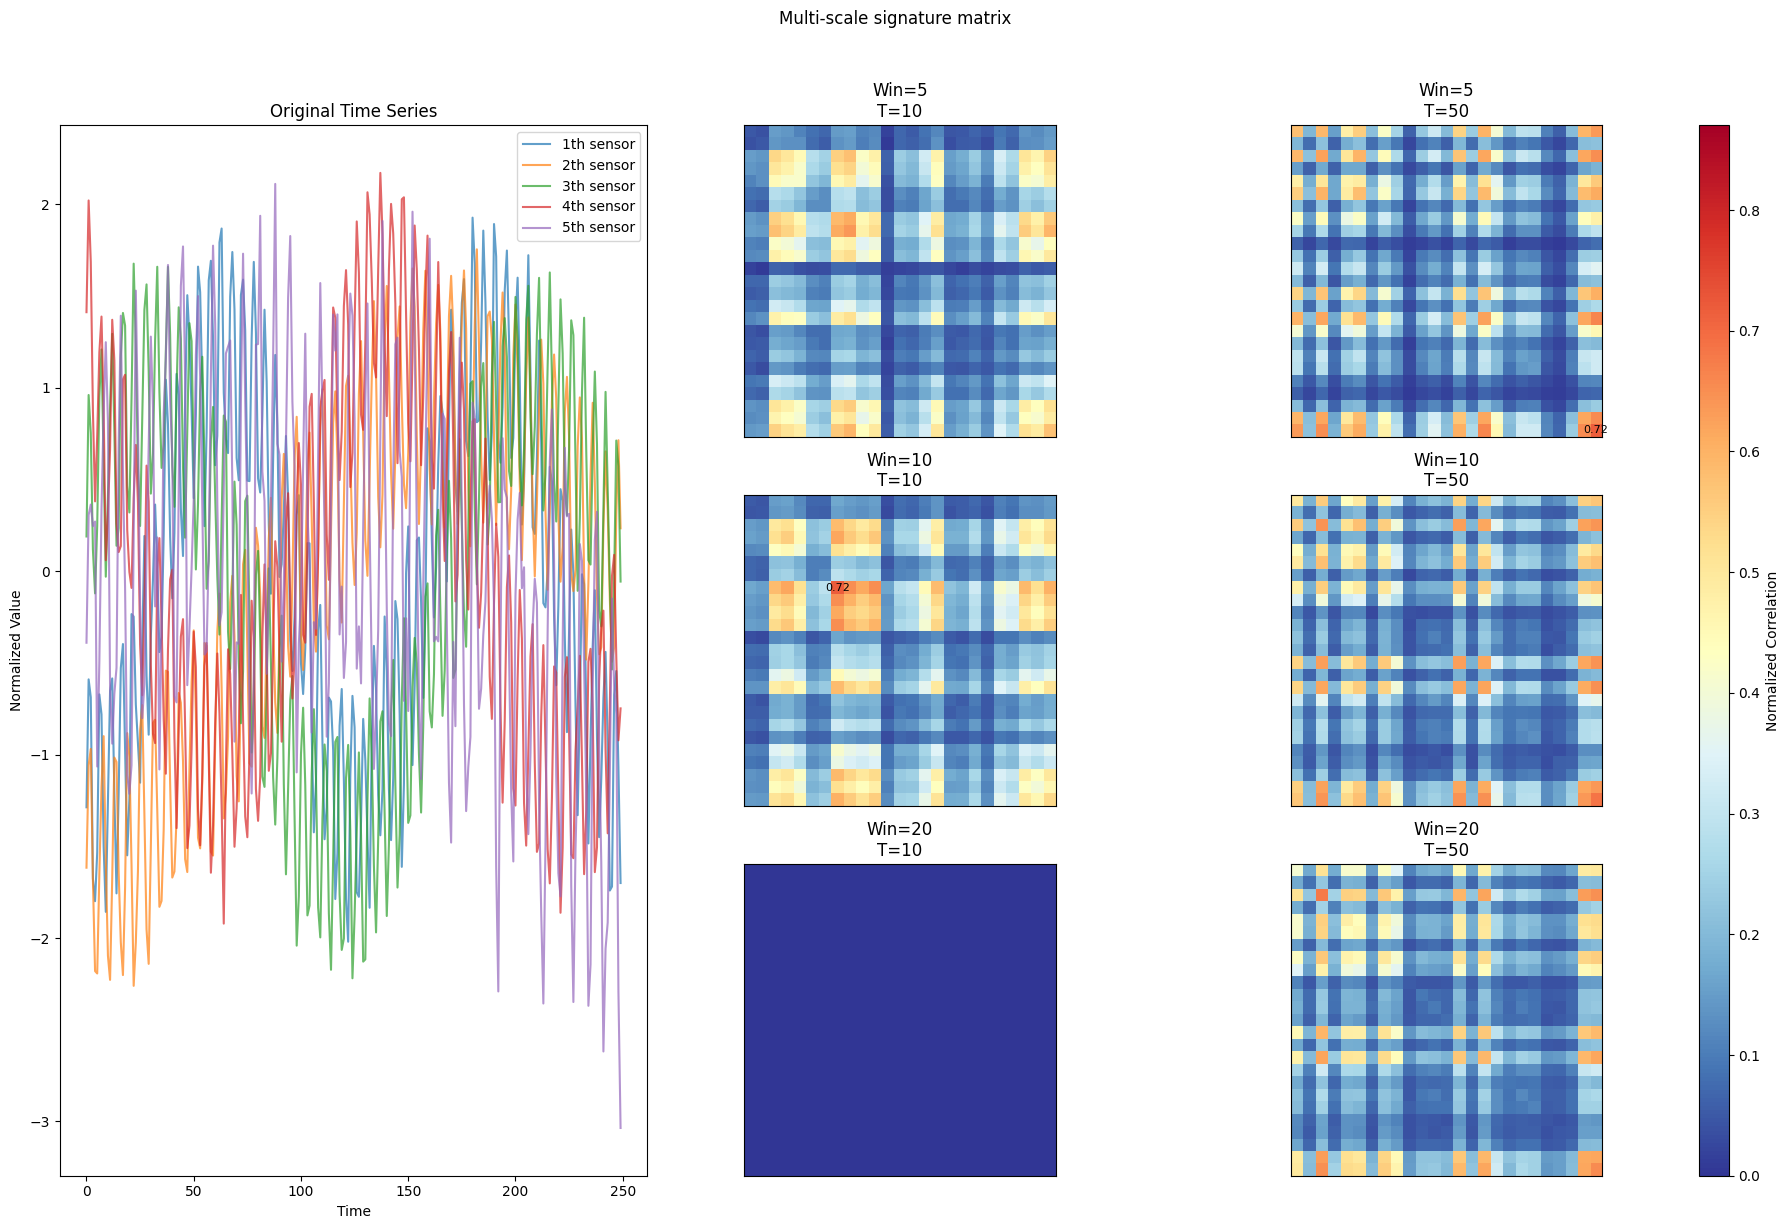

In [97]:
sample_times = [10, 50]

plot_signature_matrices(
    data=data_train,
    matrices=signature_matrices,
    win_sizes=win_size,
    gap_time=gap_time,
    sample_times=sample_times
)